# EEG Seizure Detection: EDA & Preprocessing Analysis

This notebook provides a comprehensive exploratory data analysis (EDA) of the CHB-MIT EEG dataset and validates the preprocessing pipeline.

### Objectives:
1. **Class Imbalance**: Analyze the distribution of seizure vs. normal segments.
2. **Signal Visualization**: Compare raw EEG signals with their processed counterparts.
3. **Preprocessing Validation**: Demonstrate the effectiveness of Notch and Bandpass filters using Power Spectral Density (PSD).

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne

# Add src to path
sys.path.append(str(Path(os.getcwd()).parent))

from src.data.preprocess import load_eeg_data, TARGET_CHANNELS
from src.data.dataset import parse_summary
from src.utils.config import load_config

# Plotting config
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 1. Load Configuration & Statistics

We use the centralized `config.yaml` to identify the data directories and subjects.

In [2]:
cfg = load_config("../config.yaml")
raw_dir = Path("../") / cfg.data.raw_dir
subjects = cfg.data.subjects

print(f"Raw Data Directory: {raw_dir}")
print(f"Number of Subjects: {len(subjects)}")

Raw Data Directory: ..\data\raw\chbmit
Number of Subjects: 18


## 2. Class Imbalance Analysis

We parse the summary files to count the total duration of seizure vs. normal recordings.

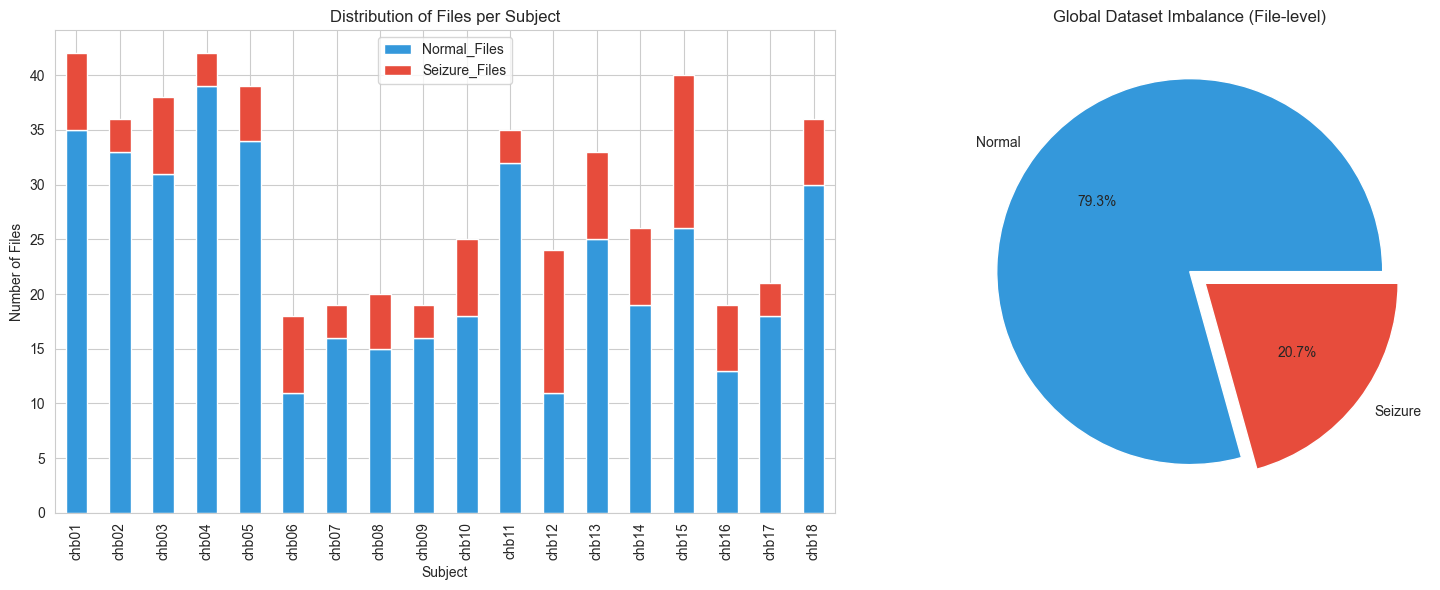

In [3]:
stats = []
for subj in subjects:
    summary_path = raw_dir / subj / f"{subj}-summary.txt"
    if summary_path.exists():
        records = parse_summary(str(summary_path))
        n_files = len(records)
        n_seizures = sum(1 for intervals in records.values() if len(intervals) > 0)
        stats.append({"Subject": subj, "Files": n_files, "Seizure_Files": n_seizures})

df_stats = pd.DataFrame(stats)
df_stats["Normal_Files"] = df_stats["Files"] - df_stats["Seizure_Files"]

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

df_stats.set_index("Subject")[["Normal_Files", "Seizure_Files"]].plot(kind="bar", stacked=True, ax=ax1, color=["#3498db", "#e74c3c"])
ax1.set_title("Distribution of Files per Subject")
ax1.set_ylabel("Number of Files")

total_normal = df_stats["Normal_Files"].sum()
total_seizure = df_stats["Seizure_Files"].sum()
ax2.pie([total_normal, total_seizure], labels=["Normal", "Seizure"], autopct='%1.1f%%', colors=["#3498db", "#e74c3c"], explode=[0, 0.1])
ax2.set_title("Global Dataset Imbalance (File-level)")

plt.tight_layout()
plt.show()

## 3. Signal Preprocessing Comparison

We take a sample EEG segment and compare the raw signal with the filtered signal (1-45Hz Bandpass + 50Hz Notch).

C:\Users\yusuf\AppData\Local\Temp\ipykernel_17044\4141521002.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_mne = mne.io.read_raw_edf(sample_file, preload=True, verbose=False)
d:\work\freelance\eeg-biometric-system\src\data\preprocess.py:121: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file_path, preload=True, verbose=verbose)


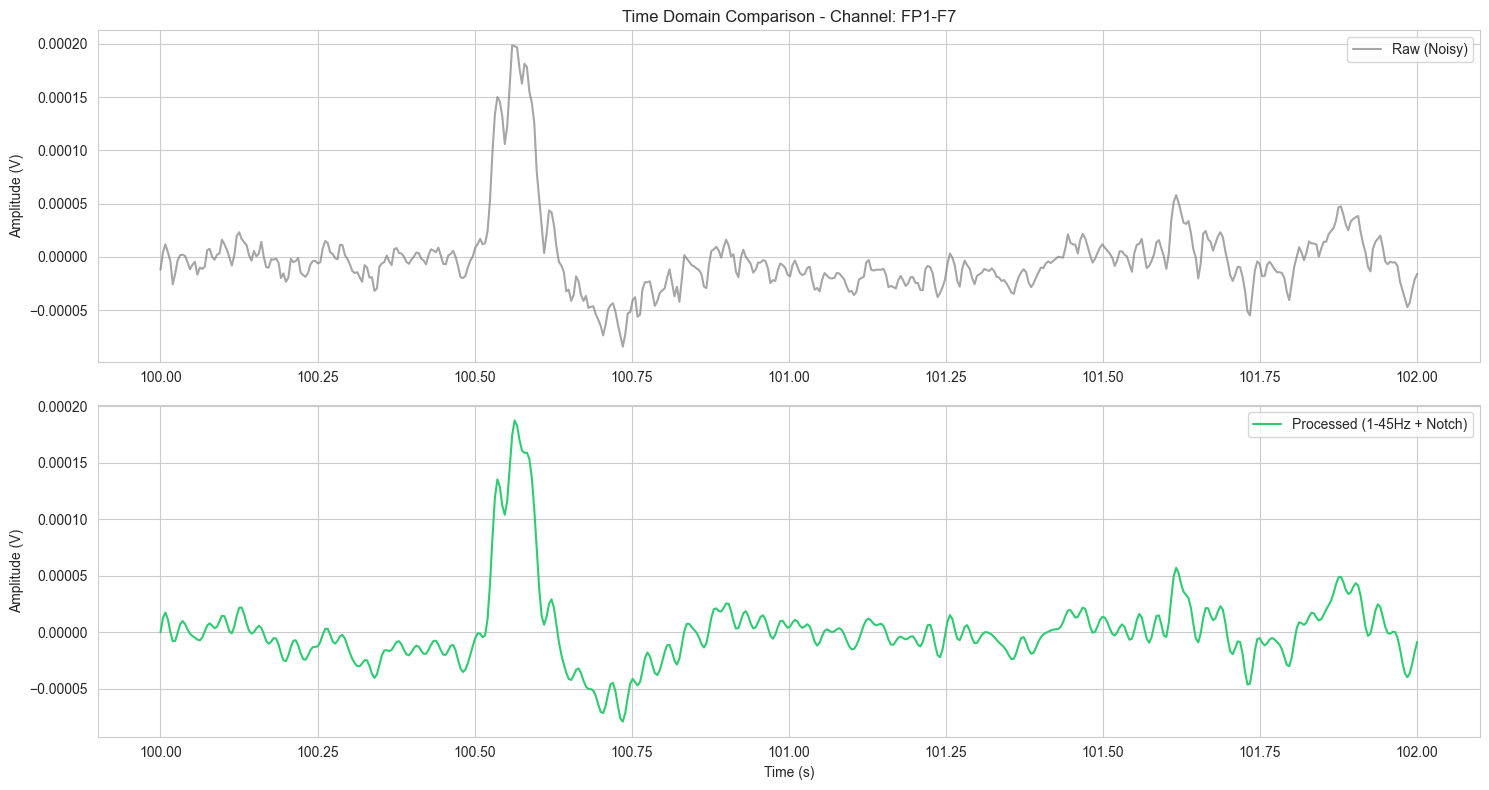

In [4]:
# Load a sample file (Subject 1, first file)
sample_subj = subjects[0]
sample_file = list((raw_dir / sample_subj).glob("*.edf"))[0]

# Load Raw (using MNE directly to keep it truly raw)
raw_mne = mne.io.read_raw_edf(sample_file, preload=True, verbose=False)
raw_mne.pick(TARGET_CHANNELS[:5]) # Pick first 5 channels for clarity
data_raw = raw_mne.get_data()
sfreq = raw_mne.info['sfreq']

# Load Processed using our pipeline
data_proc, _, _ = load_eeg_data(
    str(sample_file), 
    target_channels=TARGET_CHANNELS[:5], 
    notch_freq=50.0, 
    bandpass_low=1.0, 
    bandpass_high=45.0
)

# Visualization: Time Domain
start_sec, duration = 100, 2 # 2 seconds of data
start_idx = int(start_sec * sfreq)
end_idx = start_idx + int(duration * sfreq)
t = np.linspace(start_sec, start_sec + duration, end_idx - start_idx)

ch_idx = 0
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(t, data_raw[ch_idx, start_idx:end_idx], color='gray', alpha=0.7, label="Raw (Noisy)")
plt.title(f"Time Domain Comparison - Channel: {TARGET_CHANNELS[ch_idx]}")
plt.ylabel("Amplitude (V)")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, data_proc[ch_idx, start_idx:end_idx], color='#2ecc71', label="Processed (1-45Hz + Notch)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.legend()
plt.tight_layout()
plt.show()

## 4. Spectral Analysis (PSD)

The Power Spectral Density clearly shows the suppression of the 50Hz power-line noise and the 1-45Hz band prioritization.

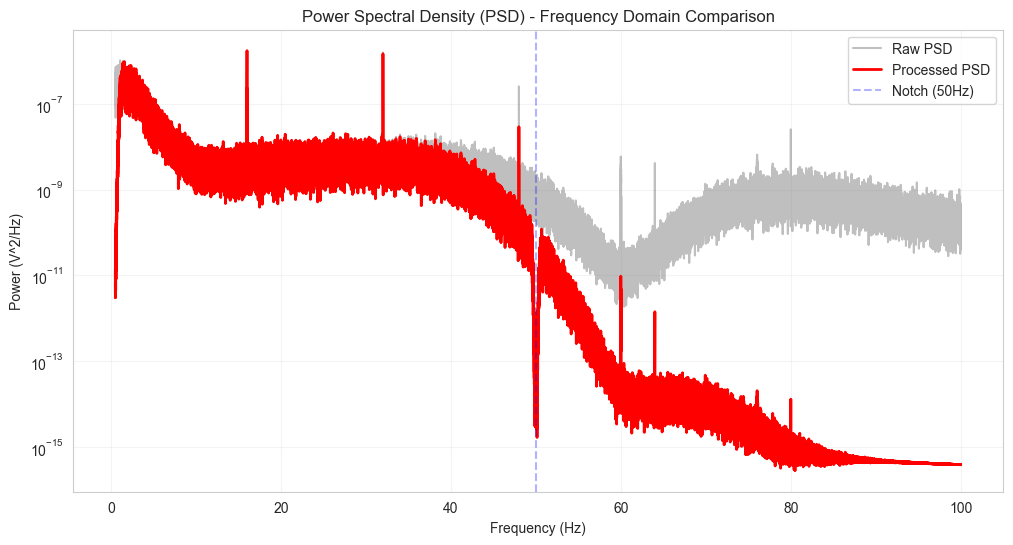

In [5]:
plt.figure(figsize=(12, 6))

# Raw PSD
psd_raw, freqs = mne.time_frequency.psd_array_multitaper(data_raw[ch_idx], sfreq, fmin=0.5, fmax=100, verbose=False)
plt.semilogy(freqs, psd_raw, color='gray', label='Raw PSD', alpha=0.5)

# Processed PSD
psd_proc, freqs = mne.time_frequency.psd_array_multitaper(data_proc[ch_idx], sfreq, fmin=0.5, fmax=100, verbose=False)
plt.semilogy(freqs, psd_proc, color='red', label='Processed PSD', linewidth=2)

plt.axvline(50, color='blue', linestyle='--', alpha=0.3, label='Notch (50Hz)')
plt.title("Power Spectral Density (PSD) - Frequency Domain Comparison")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (V^2/Hz)")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()